In [1]:
%matplotlib inline
import numpy as np
import cv2
from incisorseg.dataset import Dataset,LeaveOneOutSplitter,load_image,load_landmark
from incisorseg.utils import *
from asm.shape import Shape, ShapeList
from asm.shapemodel import ShapeModel
from asm.greymodel import GreyModel
from asm.model import ActiveShapeModel

# Reading the data

In [2]:
data = Dataset('../data/')

# Ideal case - testing the shape model fitting

3 32583.3505499


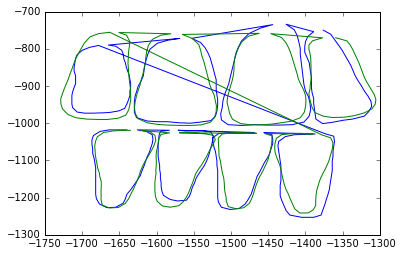

3 32068.8920118


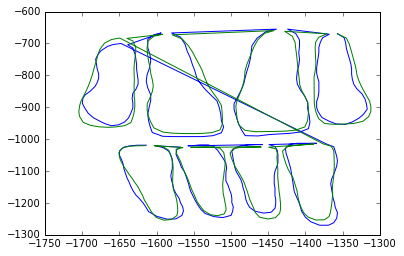

4 32611.6581748


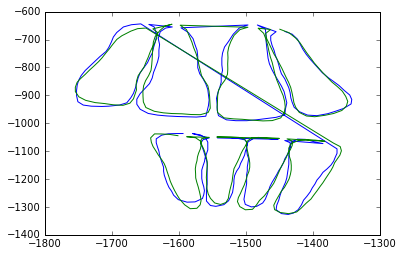

3 32500.0174153


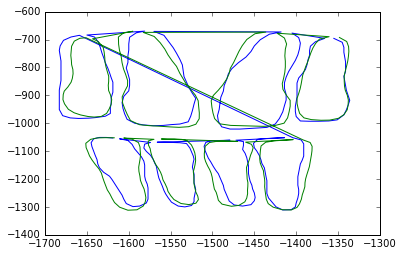

4 32677.8944483


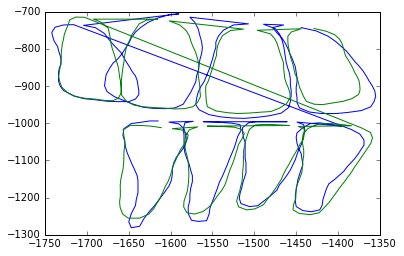

3 32205.5892233


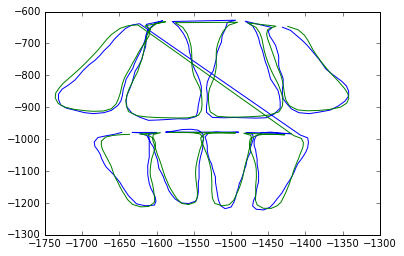

4 32187.4232532


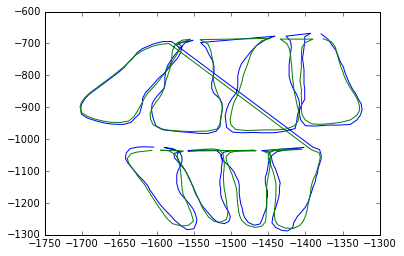

4 31561.0818141


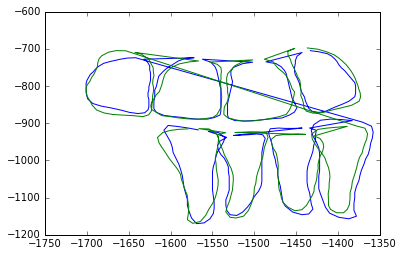

4 33121.2109359


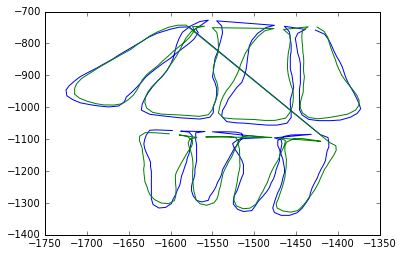

3 30818.440565


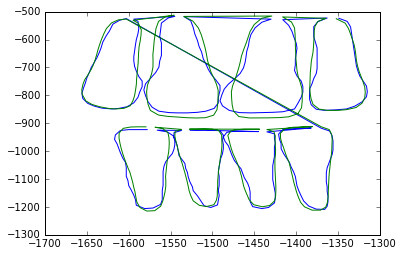

3 31634.4162599


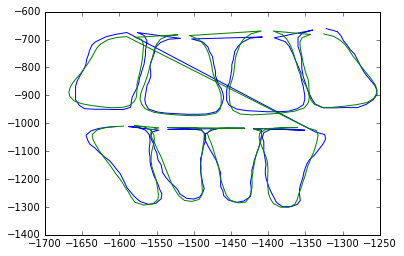

4 32432.435731


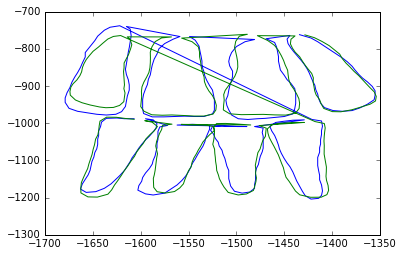

3 31131.8697871


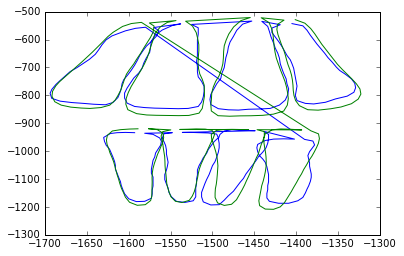

3 32197.4320065


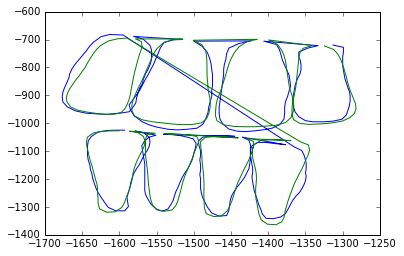

3 32296.227992


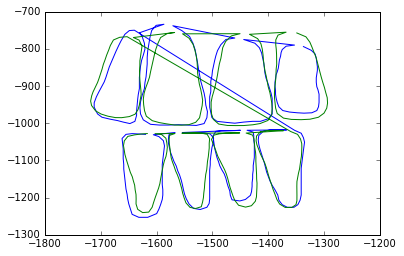

3 32342.063861


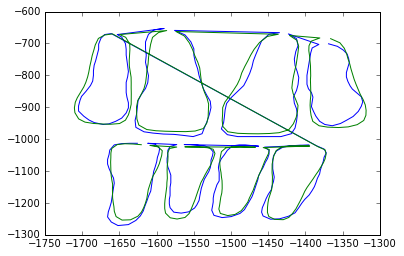

3 31551.5356118


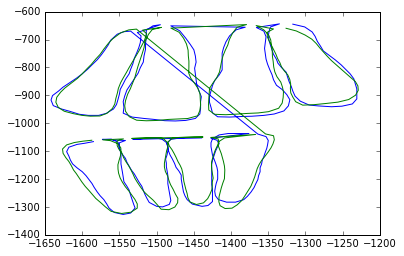

3 32553.2848692


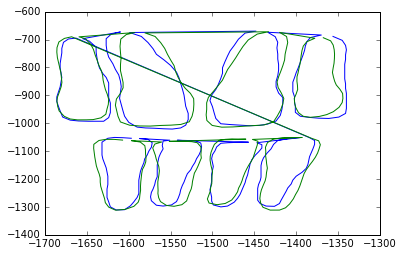

4 31821.785424


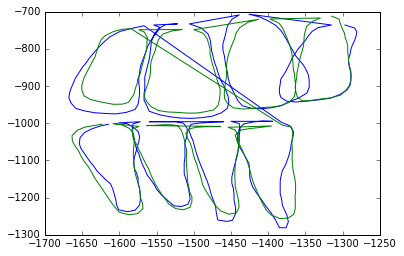

3 31446.4198044


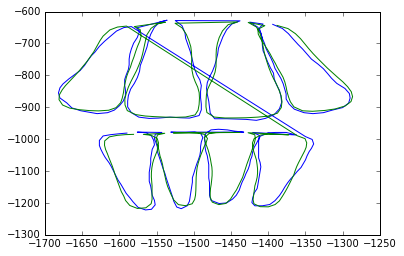

4 32429.4204756


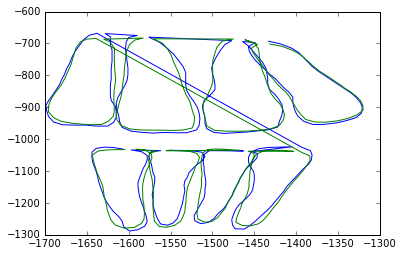

4 31608.2503045


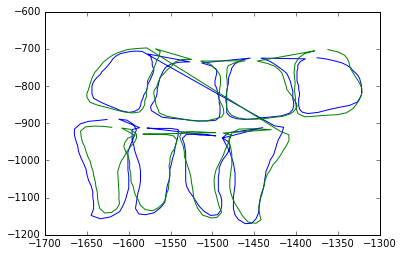

4 32603.6635263


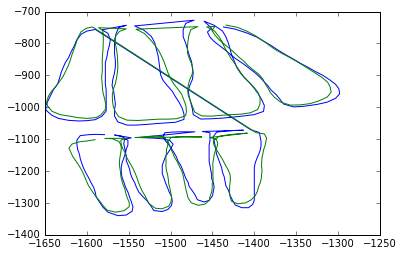

3 31697.8878745


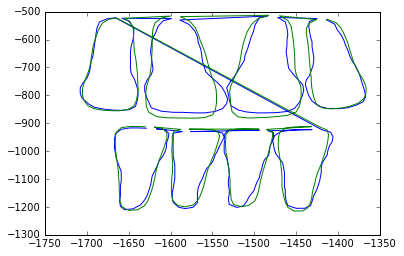

3 32883.6464621


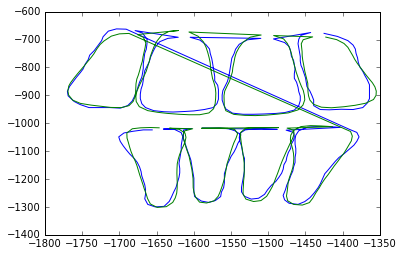

4 32038.389171


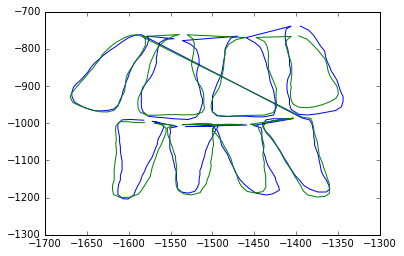

3 31381.9829228


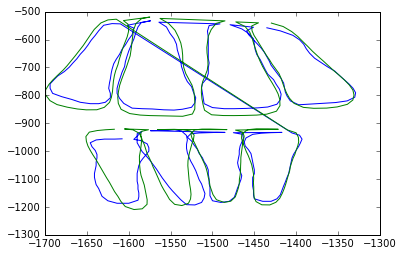

3 32987.0071083


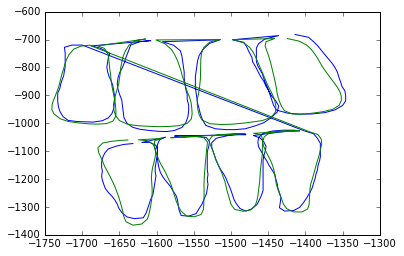

In [3]:
for split in LeaveOneOutSplitter(data):
    training_images,training_landmarks,training_segmentations = split.get_training_set()
    test_image,test_landmark,test_segmentation = split.get_test_example()
    shape_model = ShapeModel(training_landmarks)
    fitted_shape,error,num_iters =shape_model.fit(test_landmark)
    print num_iters,error
    plot_shapes([test_landmark,fitted_shape])

# Ideal case - testing the grey model fitting

In [ ]:
'''
for split in LeaveOneOutSplitter(data):
    training_images,training_landmarks,training_segmentations = split.get_training_set()
    test_image,test_landmark,test_segmentation = split.get_test_example()
    grey_model = GreyModel(training_images, training_landmarks, number_of_pixels_model=60, pca_variance_captured=0.9,
                 normal_point_neighborhood=4,
                 use_gradient=False, normalize=False, simple_model=True)
    fitted_shape,error_list =grey_model.search(test_image,test_landmark,search_number_of_pixels=120)
    shape_model = ShapeModel(training_landmarks)
    fitted_shape,error,num_iters =shape_model.fit(fitted_shape)
    print num_iters,error
    plot_shapes([test_landmark,fitted_shape])
'''

'\nfor split in LeaveOneOutSplitter(data):\n    training_images,training_landmarks,training_segmentations = split.get_training_set()\n    test_image,test_landmark,test_segmentation = split.get_test_example()\n    grey_model = GreyModel(training_images, training_landmarks, number_of_pixels_model=60, pca_variance_captured=0.9,\n                 normal_point_neighborhood=4,\n                 use_gradient=False, normalize=False, simple_model=True)\n    fitted_shape,error_list =grey_model.search(test_image,test_landmark,search_number_of_pixels=120)\n    shape_model = ShapeModel(training_landmarks)\n    fitted_shape,error,num_iters =shape_model.fit(fitted_shape)\n    print num_iters,error\n    plot_shapes([test_landmark,fitted_shape])\n'

In [ ]:
i = 0
pyr_levels = 4
for split in LeaveOneOutSplitter(data):
    training_images,training_landmarks,training_segmentations = split.get_training_set()
    test_image,test_landmark,test_segmentation = split.get_test_example()
    scaled_training_images = []
    scaled_training_landmarks = []
    scaled_test_images = []
    scaled_training_images.append(training_images)
    scaled_training_landmarks.append(training_landmarks)
    scaled_test_images.append(test_image)
    for j in range(1,pyr_levels):
        scaled_test_images.append(cv2.pyrDown(scaled_test_images[j-1]))
        scaled_training_images.append([cv2.pyrDown(image) for image in scaled_training_images[j-1]])
        scaled_training_landmarks.append(ShapeList([shape.pyr_down() for shape in scaled_training_landmarks[j-1]]))
    new_shape = None
    print 'Test Landmarks Accuracy %f',split.get_dice_error_on_test(test_landmark)
    detected_shapes = []
    for j in range(pyr_levels-1,-1,-1):
        #print scaled_training_landmarks.bounding_box()
        #print scaled_training_images[0].shape
        model = ActiveShapeModel(scaled_training_images[j],scaled_training_landmarks[j],grey_model_number_of_pixels=5,
             grey_model_search_number_of_pixels=7,grey_model_use_gradient=False,
             grey_model_normalize=False,simple_model = True)
        new_shape,fit_error,_ = model.fit(scaled_test_images[j],1e-7,50, initial_shape=new_shape)
        if j == pyr_levels-1:     
            detected_shapes.append(model.initial_shape())
        detected_shapes.append(new_shape)
        imshow2(overlay_shapes_on_image(scaled_test_images[j],[new_shape.round()]))
        plot_shapes([new_shape])
        new_shape = new_shape.pyr_up()
    i +=1
    for j in range(len(detected_shapes)):
        if j==0:
            scale_start = 1
        else:
            scale_start = j
        for k in range(scale_start,pyr_levels):
            detected_shapes[j]=detected_shapes[j].pyr_up()
        
        print 'Level:' , j, 'Accuracy',split.get_dice_error_on_test(detected_shapes[j])
            
                

Test Landmarks Accuracy %f 0.720707254052
